<a href="https://www.kaggle.com/code/mkubina/disaster-tweets-na-ve-bayes-and-bag-of-words?scriptVersionId=212374207" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [129]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv



# Predicting disaster tweets

This is my next attempt to predict which tweets regard actual disaster and which do not in the competition, using variations of text vectorizing and ML models.

This time with Naïve Bayes that treats its features as independent items and counts probality of an event **in case** another event happened. In other words, probability of actual disaster happening if tweets look particular way.


In [130]:
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag

import re

from wordcloud import WordCloud

data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [158]:
print(f"Example of disaster tweet: {data.text[data.target == 1].iloc[2]}")
print(f"Example of non-disaster tweet: {data.text[data.target == 0].iloc[42]}")

Example of disaster tweet: residents asked place notified officers evacuation shelter place orders expected
Example of non-disaster tweet: rt sleepjunkies sleeping pills double risk car accident


In [132]:
def clean_words(text, extra_stops = None):
    text = re.sub(r'(http.*)|#', '', text)
    tokens = word_tokenize(text)
    stops = stopwords.words('english') + (extra_stops if extra_stops else [])
    clean_tokens = [token.lower() for token in tokens if token.lower() not in stops and token.isalnum()]
    return ' '.join(clean_tokens)

In [133]:
data = data[["text", "target"]]
data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [159]:
data.text = data.text.apply(lambda x: clean_words(x))
test_data.text = test_data.text.apply(lambda x: clean_words(x))

data.head()

,text,target
0,deeds reason earthquake may allah forgive us,1
1,forest fire near la ronge sask canada,1
2,residents asked place notified officers evacua...,1
3,people receive wildfires evacuation orders cal...,1
4,sent photo ruby alaska smoke wildfires pours s...,1


In [135]:
def make_freq(data):
    all_tweets = " ".join(data)

    tokens = word_tokenize(all_tweets)
    frequency = FreqDist(tokens)

    return frequency

make_freq(data["text"])

FreqDist({'like': 342, 'amp': 325, 'fire': 244, 'get': 225, 'new': 208, 'people': 196, 'one': 192, 'news': 158, '2': 156, 'disaster': 151, ...})

In [161]:
disasters = data["text"][data.target == 1]
no_disasters = data["text"][data.target == 0]

make_freq(disasters)

FreqDist({'fire': 174, 'disaster': 117, 'news': 116, 'california': 110, 'police': 106, 'people': 104, 'suicide': 103, 'like': 89, 'storm': 86, 'killed': 85, ...})

In [137]:
make_freq(no_disasters)

FreqDist({'like': 253, 'amp': 195, 'get': 162, 'new': 155, 'one': 128, 'body': 108, 'would': 104, 'got': 92, 'people': 92, 'love': 88, ...})

In [138]:
extra_stops = ["amp", "get", "got", "one", "2"]

def full_prepare(data, extra_stops = None):
    data.text = data.text.apply(lambda x: clean_words(x, extra_stops))

    return data

data = full_prepare(data, extra_stops)

disasters = data["text"][data.target == 1]
no_disasters = data["text"][data.target == 0]

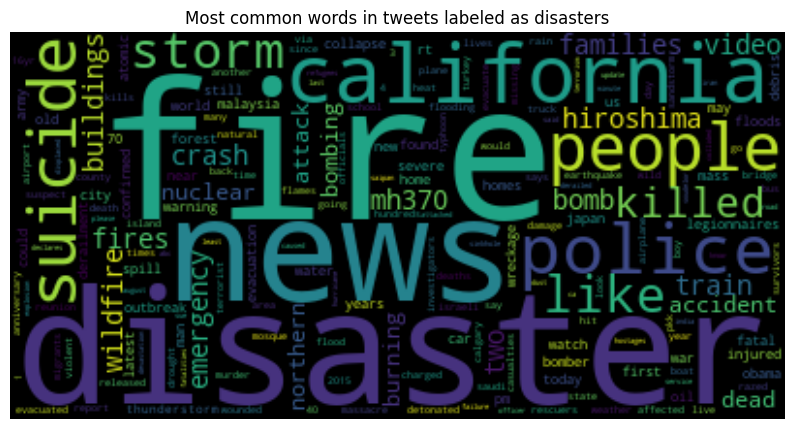

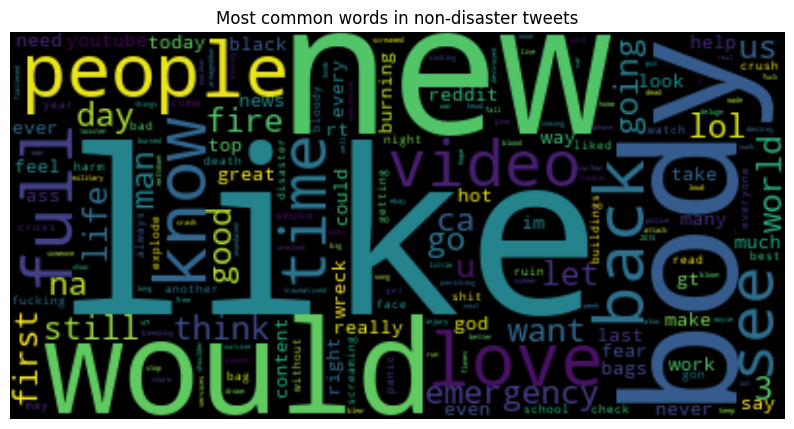

In [139]:
def make_cloud(data, title = None):
    wordcloud = WordCloud().generate_from_frequencies(make_freq(data))

    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

make_cloud(disasters, "Most common words in tweets labeled as disasters")
make_cloud(no_disasters, "Most common words in non-disaster tweets")

In [140]:
data = full_prepare(data, extra_stops)
test_data = full_prepare(test_data, extra_stops)

In [141]:
data.groupby("target").describe()

text                
       count unique top freq
target                      
0       4342   4024       31
1       3271   2783       28

## Vectorizing our tweets
Naïve Bayes is said to go especially well in modelling text data. To keep naïve (independent) nature of data we'll vectorize them into simple bag of words.



In [167]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

vectorizer = CountVectorizer()

vectors = vectorizer.fit_transform(data["text"])
test_vectors = vectorizer.transform(test_data["text"])
print(vectors[:1])

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 7 stored elements and shape (1, 15280)>
  Coords	Values
  (0, 3762)	1
  (0, 11070)	1
  (0, 4459)	1
  (0, 8558)	1
  (0, 800)	1
  (0, 5458)	1
  (0, 14327)	1


## Splitting data on train, validation and test sets
and applying some models

In [212]:
X = vectors
y = data["target"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.175)

model = MultinomialNB()

model.fit(X_train, y_train)
predictions = model.predict(X_valid)

f1 = f1_score(y_valid, predictions)
print(f'F1 score: {f1}')

F1 score: 0.7693677649154053


In [213]:
def find_good_split(X, y, size = 0.2):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = size, random_state = 42)

    model = MultinomialNB()

    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)

    f1 = f1_score(y_valid, predictions)
    print(f'F1 score: {f1}')

for size in [0.1, 0.125, 0.15, 0.175, 0.2]:
    find_good_split(X, y, size)

F1 score: 0.7409733124018839
F1 score: 0.7430730478589421
F1 score: 0.7463312368972745
F1 score: 0.7513711151736746
F1 score: 0.7472353870458136


In [170]:
find_good_split(X, y, 0.175)

F1 score: 0.7513711151736746


In [214]:
X_test = test_vectors

my_predictions = model.predict(X_test)

submission = pd.DataFrame({'id': test_data['id'],
                        'target': my_predictions})

submission.to_csv('submission.csv', index=False)